# prototyping LSS pipeline

## setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle, time, glob, sys, copy
import numpy as np 
import scipy
import mdtraj as md 
import MDAnalysis as mda
import nglview as nv 
from ipywidgets import interactive, VBox
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyemma as py 
from pyemma.util.contexts import settings
import warnings
warnings.filterwarnings('ignore')

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)
/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [4]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [5]:
import sys
#__all__ = ["hde", "propagator", "molgen"]
from hde import *#__init__, hde, propagator, molgen, analysis #

## locating trajectory data

In [76]:
timestep = 513 # ps

pdb_dir = "/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/PRB/DESRES-Trajectory_PRB-0-protein/PRB-0-protein/"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = pdb_dir
trj_file = []
for i in np.arange(0,10):
    fname = "PRB-0-protein-" + str(i).zfill(3) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
print(pdb_file)

print(pdb_file)
view = nv.show_structure_file(pdb_file)
view.clear_representations()
view.add_ball_and_stick()
view

/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/PRB/DESRES-Trajectory_PRB-0-protein/PRB-0-protein/system.pdb
/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/PRB/DESRES-Trajectory_PRB-0-protein/PRB-0-protein/system.pdb


NGLWidget()

### mdtraj load and view

In [77]:
traj_obj = md.load(trj_file, top=pdb_file)

In [78]:
traj_obj.center_coordinates(mass_weighted=False)
traj_obj.superpose(traj_obj[0])

<mdtraj.Trajectory with 100000 frames, 737 atoms, 47 residues, and unitcells at 0x7fb99e8402b0>

In [79]:
view = nv.show_mdtraj(traj_obj)
view.clear_representations()
view.add_spacefill()
view

NGLWidget(count=100000)

#### h2t

In [10]:
Ca_first_idx = traj_obj.topology.select('name CA and resid 0')
Ca_last_idx = traj_obj.topology.select('name CA and resid ' + str(traj_obj.n_residues-1))

In [11]:
h2t = md.compute_distances(traj_obj, np.reshape(np.array([Ca_first_idx, Ca_last_idx]), (1,2)), periodic=True, opt=True)

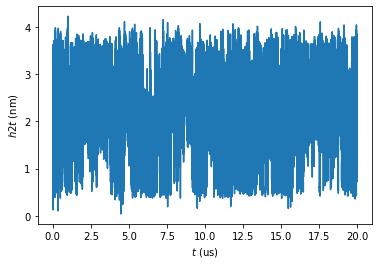

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, h2t)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

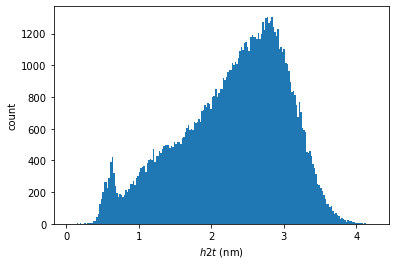

In [13]:
fig, ax = plt.subplots()
_ = plt.hist(h2t, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$h2t$ (nm)")
plt.show()

#### RMSD

In [14]:
view = nv.show_mdtraj(traj_obj[25000])
view.clear_representations()
view.add_spacefill()
view

NGLWidget()

In [15]:
rmsd = md.rmsd(traj_obj,traj_obj[25000],0)

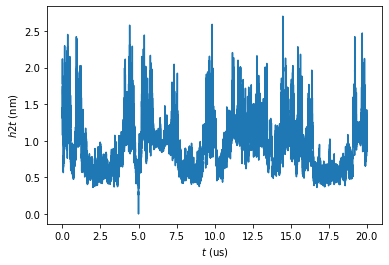

In [16]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, rmsd)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

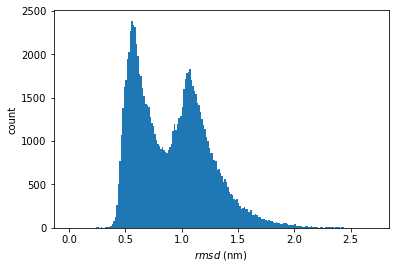

In [17]:
fig, ax = plt.subplots()
_ = plt.hist(rmsd, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$rmsd$ (nm)")
plt.show()

#### dihedrals

## featurization

In [18]:
# featurizing
features = py.coordinates.featurizer(pdb_file)
features.add_backbone_torsions(cossin=True)
features.add_sidechain_torsions(which='all', cossin=True)
atom_idx = features.select_Backbone() # select_Heavy() select_Ca()
features.add_inverse_distances(atom_idx)

#print(features.describe())
print('dim = %d' % features.dimension())

28-04-21 21:32:42 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_inverse_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
dim = 10224


In [75]:
print(features)

MDFeaturizer with features:
['COS(PHI 0 LYS 3)',
 'SIN(PHI 0 LYS 3)',
 'COS(PSI 0 LEU 2)',
 'SIN(PSI 0 LEU 2)',
 'COS(PHI 0 ASN 4)',
 'SIN(PHI 0 ASN 4)',
 'COS(PSI 0 LYS 3)',
 'SIN(PSI 0 LYS 3)',
 'COS(PHI 0 ALA 5)',
 'SIN(PHI 0 ALA 5)', ...]


In [27]:
import gc
gc.collect()




'''

data = np.zeros((0,features.dimension()))
for i in range(3):
    q = py.coordinates.load(trj_file[i], features=features, chunksize = 3)
    print(q.shape)
    data = np.concatenate((data,q), axis=0)
    print(i)
    print(data.shape)
    
'''

'\n\ndata = np.zeros((0,features.dimension()))\nfor i in range(3):\n    q = py.coordinates.load(trj_file[i], features=features, chunksize = 3)\n    print(q.shape)\n    data = np.concatenate((data,q), axis=0)\n    print(i)\n    print(data.shape)\n    \n'

## (1) latent space projection

### parameters

In [80]:
lag=50
dim=15
is_reversible=True

### SRV

In [91]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

hde = HDE(
    features.dimension(), 
    n_components=dim, 
    lag_time=lag,
    reversible=is_reversible, 
    n_epochs=300,
    learning_rate=0.0005,
    hidden_layer_depth=2,
    hidden_size=100,
    activation='tanh', 
    batch_size=20000,
    batch_normalization=True,
    #callbacks=[earlyStopping], 
    verbose=True
)

In [82]:
hde = pickle.load(open('hde.pkl', 'rb'))

In [83]:
data = np.zeros((100000,2))
for i in range(len(trj_file)):
    print(100 * i / len(trj_file), "%")
    q = py.coordinates.load(trj_file[i], features=features, chunksize = 80)
    h = hde.transform(q, side="left")
    r = i*10000
    l = (i+1*10000)
    if(i == 0):
        data = h
    else:
        data = np.concatenate((data, h), axis = 0)

0.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

10.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

20.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

30.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

40.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

50.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

60.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

70.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

80.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

90.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

In [84]:
data.shape

(100000, 15)

In [33]:
hde_coords = data
hde_timescales = hde.timescales_
print(hde_timescales)
print(hde_coords)
print(hde.eigenvalues_)


[41188.10922588 15698.38474501 13070.14835298 11720.01197814
  7135.73616534  6198.80911011  5651.36193902  5216.07443476
  4512.8086604   4455.85881471  3417.97416559  2664.59798249
  1796.07698536  1702.61846138  1312.79125932]
[[ 0.17259149 -0.02441887 -0.12985612 ... -0.48717958  0.23439598
  -0.7149806 ]
 [ 0.16897936 -0.02483911 -0.12090036 ... -0.50492996  0.2738639
  -0.7697745 ]
 [ 0.16923703 -0.02510336 -0.12437812 ... -0.5049186   0.27518848
  -0.7740008 ]
 ...
 [ 0.21980728 -0.02478896 -0.15514493 ... -0.2458954  -0.5685698
   0.50054914]
 [ 0.21914831 -0.0252205  -0.15190202 ... -0.25419822 -0.5465205
   0.4674611 ]
 [ 0.21945095 -0.02437392 -0.15558688 ... -0.2463302  -0.5498006
   0.4783704 ]]
[0.99878679 0.99682003 0.9961818  0.99574288 0.99301751 0.99196638
 0.9911916  0.99046004 0.98898158 0.98884154 0.98547793 0.9814104
 0.97254547 0.97106047 0.96262939]


Text(0.5, 1.0, "$t_i$'s BBA")

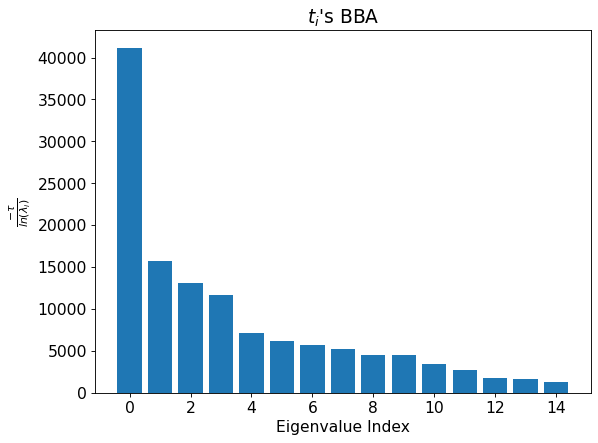

In [35]:
from matplotlib.pyplot import figure
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

heights = -lag/np.log(hde.eigenvalues_)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.bar(range(len(heights)), heights)
plt.xlabel("Eigenvalue Index")
plt.ylabel(r'$\frac{-\tau}{ln(\lambda_i)}$')
plt.title(r"$t_i$'s BBA")

<function matplotlib.pyplot.show(*args, **kw)>

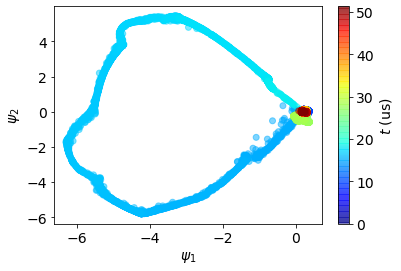

In [85]:
# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(hde_coords[:,0],hde_coords[:,1], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$\psi_2$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

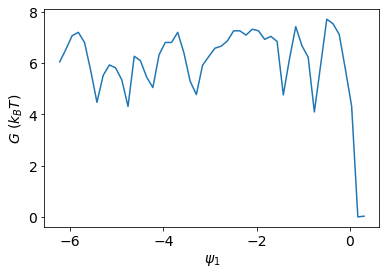

In [86]:
# 1D PMF
pdf, bin_edges = np.histogram(hde_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

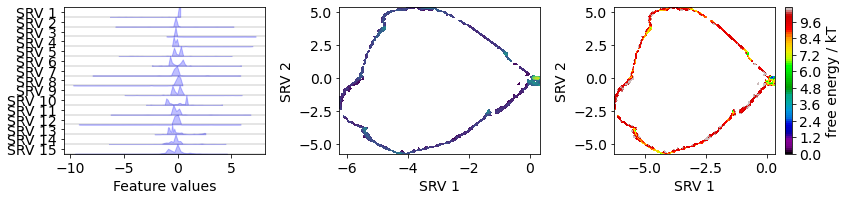

In [87]:
# pyemma distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    hde_coords, ['SRV {}'.format(i + 1) for i in range(dim)], ax=axes[0])
py.plots.plot_density(*hde_coords[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*hde_coords[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('SRV 1')
    ax.set_ylabel('SRV 2')
fig.tight_layout()

In [88]:
def plot_its(lags, its, its_stderr, dim, data_name, ax, marker='o'):

    for i in range(dim):
        ax.plot(lags,its[:,i].flatten(), marker=marker, label=data_name + ' $t$' + str(i))
        ax.fill_between(lags, its[:,i].flatten() - its_stderr[:,i].flatten(), its[:,i].flatten() + its_stderr[:,i].flatten(), alpha=0.2)
    ax.plot(lags, lags, linewidth=2, color='black')
    ax.fill_between(lags, 1e-3*np.ones(len(lags)), lags, alpha=0.5, color='grey')
    ax.set_xlim([np.min(lags), np.max(lags)])
    ax.set_ylim(ymin = np.min(lags))
    ax.set_yscale('log')
    ax.legend(loc='lower right')

15


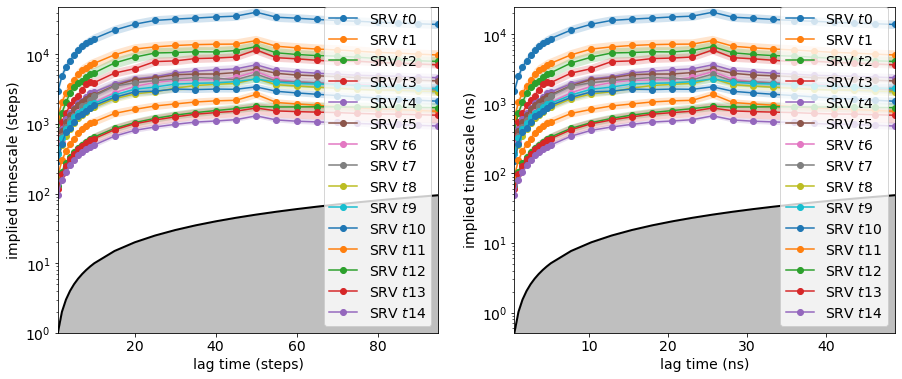

In [89]:
# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(hde_coords, lags)
print(dim)
its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(hde_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_SRV = copy.deepcopy(its)
its_SRV_stderr = copy.deepcopy(its_stderr)

### tICA

In [46]:
tica = py.coordinates.tica(data, dim=dim, lag=lag)
tica_coords = tica.get_output()[0]
print(tica.timescales[:dim])
print(tica_coords)

[41188.10208198 15698.384424   13070.15009195 11720.01216957
  7135.73874887  6198.80792158  5651.36050459  5216.07430616
  4512.80645351  4455.85828365  3417.97492364  2664.59731851
  1796.07570192  1702.61307313  1312.78461053]
[[ 0.17238246 -0.02434126 -0.12936054 ... -0.47379893  0.22760764
  -0.6882676 ]
 [ 0.16877474 -0.02476018 -0.12043898 ... -0.4910614   0.26593277
  -0.7410145 ]
 [ 0.1690321  -0.02502359 -0.12390345 ... -0.49105027  0.26721895
  -0.74508286]
 ...
 [ 0.21954052 -0.02471019 -0.15455264 ... -0.23915212 -0.5521059
   0.48184973]
 [ 0.21888237 -0.02514036 -0.15132211 ... -0.24722663 -0.5306951
   0.44999784]
 [ 0.21918464 -0.02429647 -0.15499291 ... -0.2395747  -0.5338802
   0.46049953]]


<function matplotlib.pyplot.show(*args, **kw)>

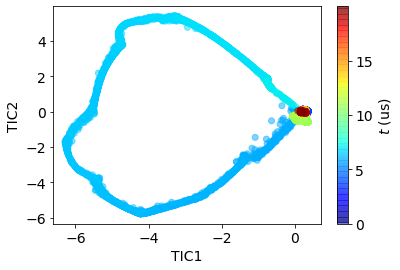

In [47]:
# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(tica_coords[:,0], tica_coords[:,1], c=np.arange(tica_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel('TIC1')
plt.ylabel('TIC2')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

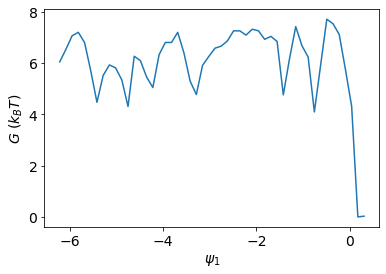

In [48]:
# 1D PMF
pdf, bin_edges = np.histogram(tica_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

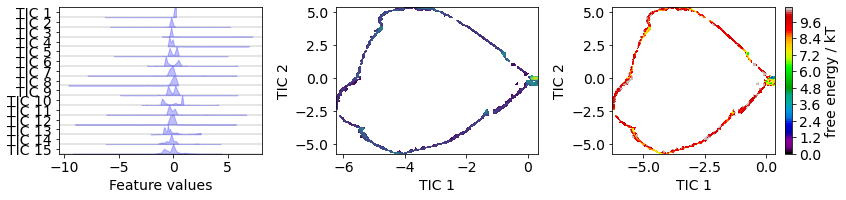

In [49]:
# pyemma distributions
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    tica_concatenated, ['TIC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
py.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
fig.tight_layout()

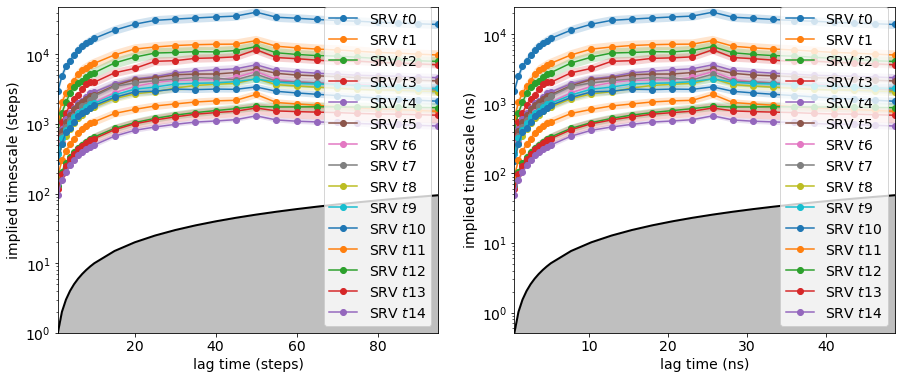

In [90]:
# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(tica_coords, lags)

its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(tica_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_TICA = copy.deepcopy(its)
its_TICA_stderr = copy.deepcopy(its_stderr)

### SRVs vs. tICA implied time scales

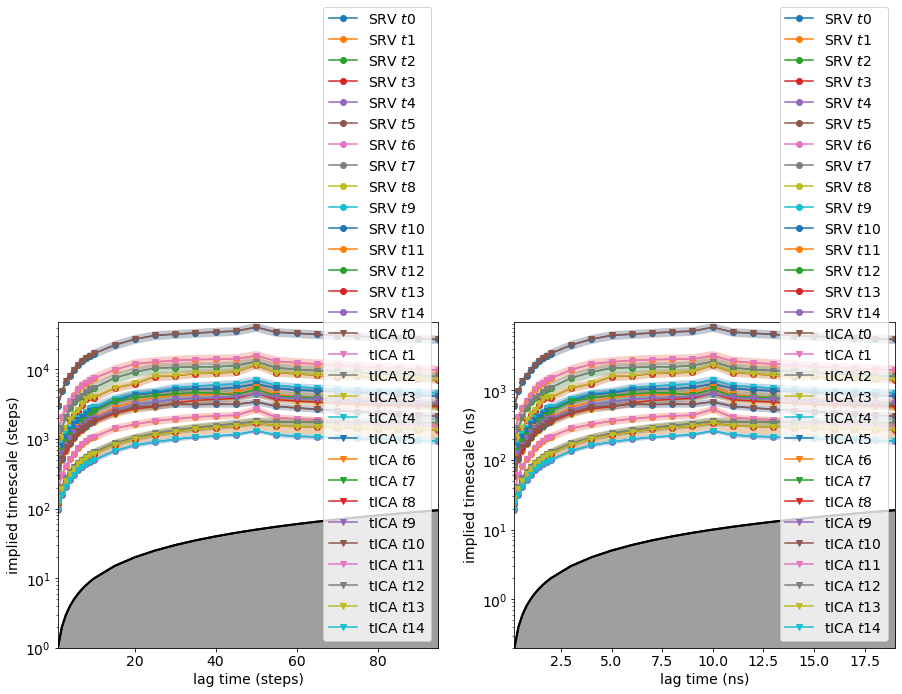

In [51]:
# implied time scales: SRVs vs. tICA

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its_SRV, its_SRV_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')
plot_its(lags, its_TICA, its_TICA_stderr, dim, 'tICA', ax[0], marker='v')

plot_its(lags*timestep/1E3, its_SRV*timestep/1E3, its_SRV_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')
plot_its(lags*timestep/1E3, its_TICA*timestep/1E3, its_TICA_stderr*timestep/1E3, dim, 'tICA', ax[1], marker='v')

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

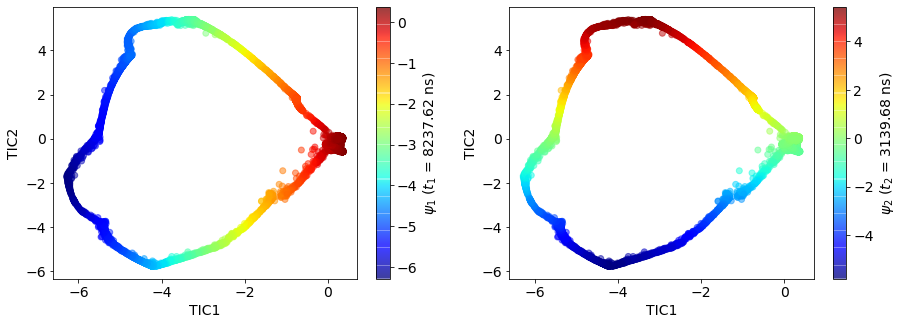

In [52]:
# 2D scatterplot
fig, ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,0], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[0])
cbar.set_label(r'$\psi_1$ ($t_1$ = ' + str(np.round(hde_timescales[0]*timestep/1E3,2)) + ' ns)')
ax[0].set_xlabel('TIC1')
ax[0].set_ylabel('TIC2')

im = ax[1].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,1], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'$\psi_2$ ($t_2$ = ' + str(np.round(hde_timescales[1]*timestep/1E3,2)) + ' ns)')
ax[1].set_xlabel('TIC1')
ax[1].set_ylabel('TIC2')

plt.show

### kernel TICA

## (2) propagator

In [92]:
dim_prop = 2

In [93]:
traj_prop = copy.deepcopy(hde_coords[:,:dim_prop])

In [94]:
prop_scaler = pre.MinMaxScaler(feature_range=(0,1))
if dim_prop==1:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop.reshape(-1, 1))
else:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [95]:
n_mix = 25
lag_prop = lag
lr_prop = 0.0001

In [96]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
]

In [97]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag_prop, 
    batch_size=200000, 
    learning_rate=lr_prop, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

In [98]:
from hde.propagator import get_mixture_loss_func

In [99]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=lr_prop))

In [100]:
prop.model.set_weights(pickle.load(open('prop_weights.pkl', 'rb')))

In [101]:
n_steps = np.int(np.floor(np.float(hde_coords.shape[0])/np.float(lag_prop)))
n_traj = 5
synth_trajs_scaled = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), n_steps).reshape(n_steps, -1) for item in range(n_traj)]
synth_trajs = [prop_scaler.inverse_transform(synth_trajs_scaled[i]) for i in range(n_traj)]

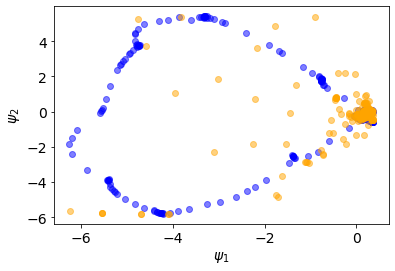

In [102]:
synth_traj_id = 0
fig, ax = plt.subplots()

if dim_prop==1:
    ax.scatter(hde_coords[::lag_prop,0], np.zeors(hde_coords[::lag_prop,0].shape[0]), c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], np.zeros(synth_trajs[synth_traj_id][:,0].shape[0]), c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')
else:
    ax.scatter(hde_coords[::lag_prop,0], hde_coords[::lag_prop,1], c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], synth_trajs[synth_traj_id][:,1], c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')

plt.show()

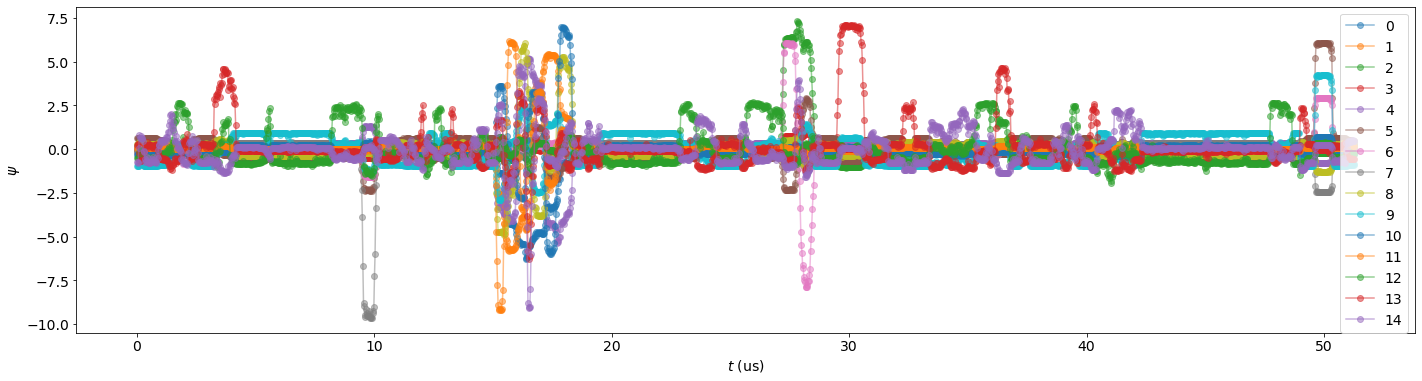

(2000, 15)


In [103]:
synth_traj_id = 1
psi_id = 0

fig, ax = plt.subplots(figsize=(24, 6))
for i in range(15):
    psi_id = i
    ax.plot(np.arange(hde_coords[::lag_prop,psi_id].shape[0])*timestep/1E6*lag_prop, hde_coords[::lag_prop,psi_id], alpha=0.5, marker='o', label=i)
psi_id = 1
plt.legend()
#ax.plot(np.arange(synth_trajs[synth_traj_id].shape[0])*timestep/1E6*lag_prop, synth_trajs[synth_traj_id][:,psi_id], color='orange', alpha=0.5, marker='o')
ax.set_xlabel(r'$t$ (us)')
ax.set_ylabel(r'$\psi$')
plt.show()
print(hde_coords[::lag_prop].shape)

## (3) generator

#### x_train = scaled latent space coordinates

In [41]:
x_train = traj_prop_scaled

#### y_train = aligned molecular configurations

In [42]:
ca_idx = traj_obj.top.select_atom_indices('alpha')
traj_ca = traj_obj.atom_slice(ca_idx)

In [43]:
traj_ca.superpose(traj_ca[0])

<mdtraj.Trajectory with 100000 frames, 47 atoms, 47 residues, and unitcells at 0x7fe0fb31f358>

In [44]:
view = nv.show_mdtraj(traj_ca[::lag_prop])
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='blue', opacity=0.6)
view
view

NGLWidget(count=2000)

In [45]:
xyz = traj_ca.xyz.reshape(-1, traj_ca.n_atoms*3)

In [46]:
xyz_scaler = pre.MinMaxScaler(feature_range=(-1,1))

In [47]:
y_train = xyz_scaler.fit_transform(xyz)

In [48]:
n_atoms = traj_ca.n_atoms

#### training cWGAN

In [49]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=30000,
    noise_dim=50,
    n_epochs=2500,
    hidden_layer_depth=2,
    hidden_size=200,
    n_discriminator=5
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               10600     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 141)               28341     
Total params: 79,141
Trainable params: 79,141
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               28800     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_

In [50]:
def swish(x):
    return (K.sigmoid(x) * x)
molgen.generator = tf.keras.models.load_model('molgen_generator.h5', custom_objects={'swish': swish},compile=False)
molgen.discriminator = tf.keras.models.load_model('molgen_discriminator.h5', custom_objects={'swish': swish},compile=False)
molgen.is_fitted = True# need to override after loading to allow molgen.transform to proceed


#### decoding synthetic propagator trajectories

In [51]:
assert molgen.is_fitted == True
print(len(synth_trajs_scaled[synth_traj_id]))

2000


In [52]:
synth_traj_id = 1
xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)
xyz_synth

array([[[-0.7066968 , -0.4783453 ,  0.5703845 ],
        [-0.75586796, -0.5402537 ,  0.6146757 ],
        [-0.74915713, -0.284083  ,  0.5760893 ],
        ...,
        [ 0.87662077,  0.05307313, -0.98704207],
        [ 0.96651006,  0.03832243, -0.9362242 ],
        [ 0.8957558 ,  0.3219059 , -1.1338938 ]],

       [[-1.244694  ,  0.32338616,  1.1739234 ],
        [-0.9869516 ,  0.08975527,  1.4078869 ],
        [-0.665843  ,  0.091915  ,  0.81022125],
        ...,
        [ 0.74270844,  0.24712858, -0.5612646 ],
        [ 0.5296988 , -0.05672137, -0.2587238 ],
        [ 0.7935197 ,  0.10141175, -0.6705123 ]],

       [[-1.0500089 ,  0.1736957 ,  1.3694227 ],
        [-0.99317604,  0.3777046 ,  1.5488818 ],
        [-0.7621323 ,  0.6462877 ,  0.74748784],
        ...,
        [-0.82826036, -0.85452724, -1.145358  ],
        [-1.1945443 , -0.8600215 , -1.5587454 ],
        [-1.2743922 , -0.8829959 , -0.8477271 ]],

       ...,

       [[-0.6689009 ,  0.9060148 ,  0.4819926 ],
        [-0

In [53]:
with open('synth.xyz', 'w') as f:
    for i in range(xyz_synth.shape[0]):
        f.write('%d\n' % n_atoms)
        f.write('\n')
        for k in range(n_atoms):
            f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

In [54]:
traj_ca[0].save_pdb('synth.pdb')

In [55]:
traj_ca_synth = copy.deepcopy(traj_ca)

In [56]:
traj_ca_synth

<mdtraj.Trajectory with 100000 frames, 47 atoms, 47 residues, and unitcells at 0x7fe0faf7a710>

In [57]:
traj_synth_obj = md.load('synth.xyz', top='synth.pdb')

In [58]:
traj_synth_obj.center_coordinates(mass_weighted=False)
traj_synth_obj.superpose(traj_synth_obj[0])

<mdtraj.Trajectory with 2000 frames, 47 atoms, 47 residues, without unitcells at 0x7fe0faf0fe80>

In [59]:
view = nv.show_mdtraj(traj_synth_obj)
view.component_0.clear_representations()
view.component_0.add_ribbon(color='red', opacity=0.6)
view

NGLWidget(count=2000)

## (4) comparison

### thermodynamics (FES)

1D PMF in leading SRV coordinate

adding one pseudo-count to each bin as regularization and avoiding infinite free energies


In [60]:
# MD 1D PMF mean
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,0], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,0])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

In [61]:
# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,0],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

In [62]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

<function matplotlib.pyplot.show(*args, **kw)>

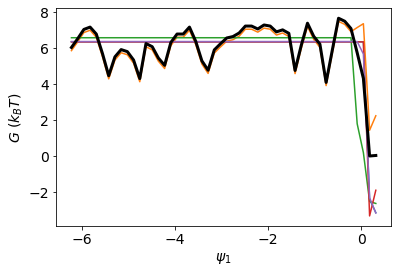

In [63]:
# plotting full and block PMFs
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_MD_block[i])
im = ax.plot(bin_mids, pmf_MD, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

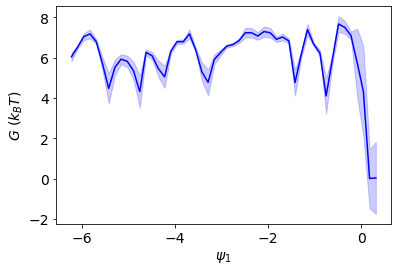

In [64]:
# plotting full PMFs with 95% CI (1.96 standard deviations in standard error)
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [67]:
# LSS 1D PMF mean
synth_trajs_CONCAT = np.zeros((0,))
for i in range(n_traj):
    synth_trajs_CONCAT = np.concatenate((synth_trajs_CONCAT,synth_trajs[i][:,0]), axis=0)
pdf_LSS, _ = np.histogram(synth_trajs_CONCAT, bins=n_bins, density=True)

pdf_LSS += 1./(len(synth_trajs_CONCAT)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_LSS = -np.log(pdf_LSS)
pmf_LSS -= np.mean(pmf_LSS[np.isfinite(pmf_LSS)]) # optimal mutual least squares alignment

In [68]:
# LSS 1D PMF block averages
pmf_LSS_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(synth_trajs_CONCAT,n_blocks,axis=0)[i] #block splits
    
    pdf_LSS_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_LSS_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_LSS_i = -np.log(pdf_LSS_i)
    pmf_LSS_i -= np.mean(pmf_LSS_i[np.isfinite(pmf_LSS_i)]) # optimal mutual least squares alignment
    pmf_LSS_block.append(pmf_LSS_i)
    
pmf_LSS_block = np.array(pmf_LSS_block)
pmf_LSS_stderr = np.std(pmf_LSS_block, axis=0)/np.sqrt(n_blocks)

In [69]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_LSS)
pmf_LSS -= PMF_shift
for i in range(n_blocks):
    pmf_LSS_block[i] -= PMF_shift

[6.08627401 5.79855295 7.18521975 6.49182426 7.18521975 5.79855295
 7.18521975 7.18521975 6.49182247 6.0862764  6.08627401 5.57538458
 6.08627401 5.79855295 6.08627401 7.18521975 5.79855027 7.18521975
 7.18521975 6.49182337 6.49182337 7.18521975 7.18521975 6.49182337
 6.08627401 7.18521975 7.18521975 6.49182337 6.08627521 7.18521975
 6.49182337 7.18521975 6.08627521 6.08627521 5.79855161 7.18521975
 6.08627521 5.79855094 6.08627521 5.23888244 7.18521975 6.08627521
 6.08627521 4.88218594 5.57538297 5.23888244 4.98755209 4.0937015
 0.2620779  0.40821487]


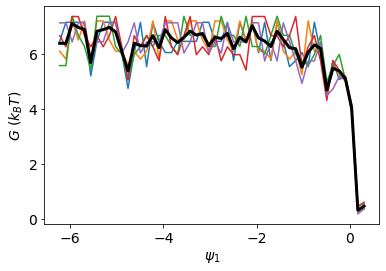

In [70]:
x = np.zeros(len(pmf_LSS_block[0]))
fig, ax = plt.subplots()
for i in range(n_blocks):
    x += pmf_LSS_block[i]/n_blocks
    ax.plot(bin_mids, pmf_LSS_block[i])
im = ax.plot(bin_mids, x, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show
print(pmf_LSS_block[1])
pmf_LSS = x

<function matplotlib.pyplot.show(*args, **kw)>

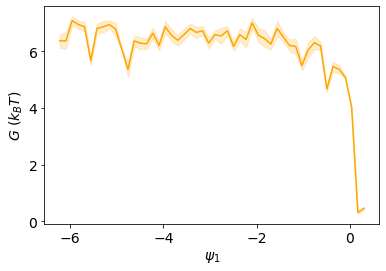

In [71]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_LSS, color='orange')
ax.fill_between(bin_mids, pmf_LSS-pmf_LSS_stderr, pmf_LSS+pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

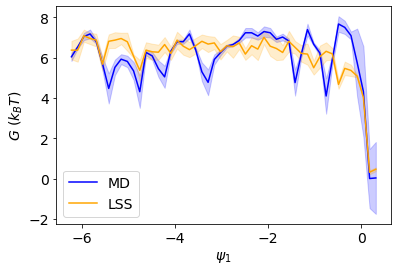

In [72]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue', label='MD')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
ax.plot(bin_mids, pmf_LSS, color='orange', label='LSS')
ax.fill_between(bin_mids, pmf_LSS-1.96*pmf_LSS_stderr, pmf_LSS+1.96*pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
ax.legend()
plt.show

<h3> $\psi_2$ thermo </h3>

In [73]:
# MD 1D PMF mean
psi_index = 1
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,psi_index], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,psi_index])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

In [74]:
# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,psi_index],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

In [75]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

### kinetic (relaxation times)

In [76]:
def compute_autocorr_time(signal, delays):
    ac=[]
    for j in delays:
        if type(signal) is list:
            z = np.concatenate([item[:] for item in signal])
            x = np.concatenate([item[:-j] for item in signal])
            y = np.concatenate([item[j:] for item in signal])
        else:
            z = signal[:]
            x = signal[:-j]
            y = signal[j:]
        ac.append(np.mean(x*y, axis=0)/np.mean(z*z, axis=0))
    return np.array(ac)

In [77]:
# MD mean autocorrelation and implied relaxation time
ac_MD = compute_autocorr_time(hde_coords[:,:dim_prop], [lag_prop])
relax_MD = -lag_prop/np.log(ac_MD)*timestep/1E3

In [78]:
# MD block average standard error estimate
ac_MD_block = []
n_blocks=5
for i in range(n_blocks):
    ac_MD_i = compute_autocorr_time(np.array_split(hde_coords[:,:dim_prop],n_blocks,axis=0)[i], [lag_prop])
    ac_MD_block.append(ac_MD_i)
ac_MD_block = np.array(ac_MD_block)
ac_MD_block = ac_MD_block.reshape(n_blocks,dim_prop)

relax_MD_block = -lag_prop/np.log(ac_MD_block)*timestep/1E3
relax_MD_stderr = np.std(relax_MD_block, axis=0)/np.sqrt(n_blocks)

In [79]:
print('MD relaxation times (ns) = ')
for i in range(relax_MD.shape[1]):
    print('%f +/- %f' % (relax_MD[0,i], relax_MD_stderr[i]))

MD relaxation times (ns) = 
13293.362305 +/- 56722.136719
3764.565430 +/- 2878.888916


In [80]:
# LSS mean autocorrelation and implied relaxation time
ac_LSS = compute_autocorr_time(synth_trajs, [1])
relax_LSS = -lag_prop/np.log(ac_LSS)*timestep/1E3

In [81]:
# LSS block average standard error estimate
# N.B. Blocks in this case are over complete indepenent LSS trajectories since data must be continuous

assert n_traj >= 5 # need at least 5 independent trajectories for reasonable blocks

ac_LSS_block = []
for i in range(n_traj):
    ac_LSS_i = compute_autocorr_time(synth_trajs[i], [1])
    ac_LSS_block.append(ac_LSS_i)
ac_LSS_block = np.array(ac_LSS_block)
ac_LSS_block = ac_LSS_block.reshape(n_traj,synth_trajs[0].shape[1])

relax_LSS_block = -lag_prop/np.log(ac_LSS_block)*timestep/1E3
relax_LSS_stderr = np.std(relax_LSS_block, axis=0)/np.sqrt(n_traj)

In [82]:
print('LSS relaxation times (ns) = ')
for i in range(relax_LSS.shape[1]):
    print('%f +/- %f' % (relax_LSS[0,i], relax_LSS_stderr[i]))

LSS relaxation times (ns) = 
25.605724 +/- 3.062783
9.620872 +/- 1.655584


### structure (RMSD)

In [154]:
#xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)

In [84]:
def writeToXYZ(xyz_coordinates, filename):
    with open(filename, 'w') as f:
        for i in range(xyz_coordinates.shape[0]):
            f.write('%d\n' % n_atoms)
            f.write('\n')
            for k in range(n_atoms):
                f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

                
def xyzToTraj(xyz_coordinates,fn="temp.xyz"):
    writeToXYZ(xyz_coordinates, fn)
    traj = md.load(fn, top='synth.pdb')
    return traj

In [83]:
'''
    ~~~RMSD Calculation~~~
    k = frames where the indexed LSS trajectory is in the metastable basin1
    l = frames where the MD obj trajectory is in the mestable basin1
    
    n = frames where the indexed LSS trajectory is in the metastable basin2
    m = frames where the MD obj trajectory is in the mestable basin2

    t = traj containing all corresponding LSS frames for basin 1
    s = traj containing all corresponding LSS frames for basin 2
    
'''
lowerBasin1 = -1.9
upperBasin1 = -1.5

lowerBasin2 = 0.5
upperBasin2 = 0.9


l = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin1, hde_coords[:,0]<=upperBasin1))
m = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))


for i in range(len(synth_trajs)):
    print("Finding Frames for Traj ",i)
    k = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin1, synth_trajs[0][:,0]<=upperBasin1))
    n = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin2, synth_trajs[0][:,0]<=upperBasin2))
    xyzi = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[i])).reshape(-1, n_atoms, 3)
    if(i == 0): t = xyzToTraj(xyzi)[k]
    else: t = md.join([t,xyzToTraj(xyzi)[k]])
    if(i == 0): s = xyzToTraj(xyzi)[n]
    else: s = md.join([t,xyzToTraj(xyzi)[n]])

Finding Frames for Traj  0


NameError: name 'xyzToTraj' is not defined

In [159]:
rmsd1 = np.mean(md.rmsd(t, traj_ca[l]))
rmsd2 = np.mean(md.rmsd(s, traj_ca[m]))
print("Basin One RMSD is ", rmsd1, " nm. Found ", len(t), "LSS frames in Basin One and ", len(l[0]), " MD frames")
print("Basin Two RMSD is ", rmsd2, " nm. Found ", len(s), "LSS frames in Basin Two and ", len(m[0]), " MD frames")

Basin One RMSD is  0.77275634  nm. Found  1450 LSS frames in Basin One and  23695  MD frames
Basin Two RMSD is  0.94161195  nm. Found  2580 LSS frames in Basin Two and  67734  MD frames


In [ ]:
np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))

In [ ]:
67734/23695